In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.linear_model import LinearRegression

In [2]:
# load data
raw_data = pd.read_csv("Tractores_Matriculados.csv")
complete_data = raw_data.copy()
print(raw_data.head(), "\n")  # check data structure
print(raw_data.dtypes)  # check data types

        Fecha  Tractores
0  1986-01-31     1965.0
1  1986-02-28     1467.0
2  1986-03-31     1106.0
3  1986-04-30     1460.0
4  1986-05-31     1563.0 

Fecha         object
Tractores    float64
dtype: object


In [3]:
raw_data.Fecha.describe()
pd.to_datetime(raw_data.Fecha, yearfirst=True)  # convert to datetime format
print(raw_data.dtypes, "\n")

Fecha         object
Tractores    float64
dtype: object 



### Statistics


In [4]:
print(raw_data.describe(), "\n")  # summary statistics
print(raw_data.isna())  # check for missing values

"""
we can use raw_data.Fecha.descibe() to get a summary of the date column
"""

""" 
we can see in a specific column if there are missing values with: 
raw_data['column_name'].isna().sum()
"""

         Tractores
count   125.000000
mean   1531.120000
std     425.232889
min     639.000000
25%    1210.000000
50%    1487.000000
75%    1773.000000
max    2734.000000 

     Fecha  Tractores
0    False      False
1    False      False
2    False      False
3    False      False
4    False      False
..     ...        ...
127  False       True
128  False       True
129  False       True
130  False       True
131  False       True

[132 rows x 2 columns]


" \nwe can see in a specific column if there are missing values with: \nraw_data['column_name'].isna().sum()\n"

In [5]:
# Filter data between 1988 t 1994
data = raw_data[
    (raw_data.Fecha >= "1986-01-31 00:00:00")
    & (raw_data.Fecha <= "1995-12-31 00:00:00")
]

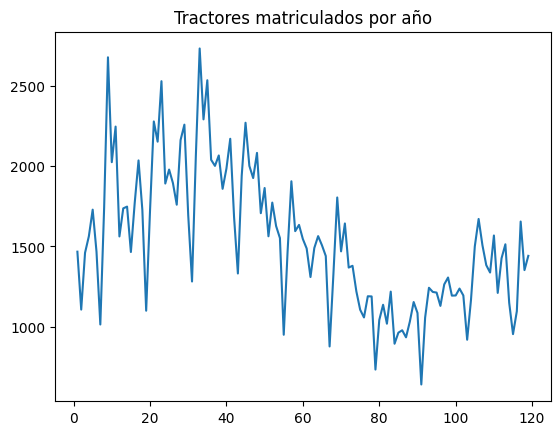

In [6]:
# Show time series
data.Tractores.plot(
    x="Fecha", y="Tractores", kind="line", title="Tractores matriculados por año"
)
plt.show()

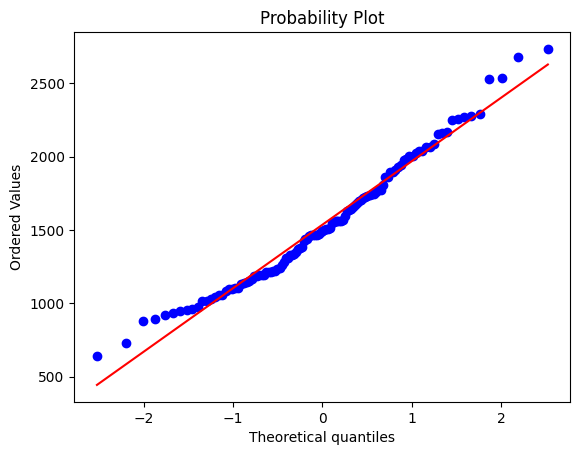

In [7]:
import scipy.stats as stats
import pylab

# Check for normality
stats.probplot(data.Tractores, dist="norm", plot=pylab)
pylab.show()

In [8]:
data.head()

,Fecha,Tractores
1,1986-02-28,1467.0
2,1986-03-31,1106.0
3,1986-04-30,1460.0
4,1986-05-31,1563.0
5,1986-06-30,1729.0


In [9]:
# Set date as index column and sort by date
data.set_index("Fecha", inplace=True)
data.head()

,Tractores
Fecha,
1986-02-28,1467.0
1986-03-31,1106.0
1986-04-30,1460.0
1986-05-31,1563.0
1986-06-30,1729.0


In [10]:
# data = data.asfreq("m")  # set frequency to monthly data
# data.head(50)

""" No funciona, no se puede convertir a frecuencia mensual -- da error"""